# Face Recognition Demo
- with VGG face extractor
- and CV DNN face detector
- and LFW dataset

In [21]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
from glob import glob
from random import randint
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.settings import types
from app.utils import im_utils, file_utils
from app.models.bbox import BBox
from app.models.data_store import DataStore
from app.processors import face_detector, face_extractor

from app.models.bbox import BBox

In [5]:
data_store = DataStore(types.DataStore.HDD, types.Dataset.LFW)

## Files

In [37]:
fp_records = data_store.metadata(types.Metadata.FILE_RECORD)
df_records = pd.read_csv(fp_records, dtype={'fn':str}).set_index('index')

fp_roi = data_store.metadata(types.Metadata.FACE_ROI)
df_roi = pd.read_csv(fp_roi).set_index('index')

fp_vector = data_store.metadata(types.Metadata.FACE_VECTOR)
df_vector = pd.read_csv(fp_vector).set_index('index')

### Load vectors

In [38]:
# Takes a while
# convert the CSV to float list of vecs
vecs_all = [list(map(float, x.vec.split(','))) for x in df_vector.itertuples()]

### Detect Face

- use OpenCV DNN detector

/data_store_hdd/datasets/people/lfw/media/original/Mike_Martz/Mike_Martz_0007.jpg


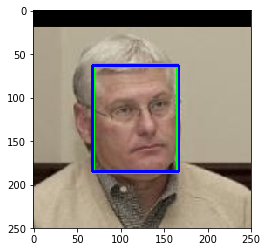

In [43]:
rn = randint(0,len(df_records))
ds_record = df_records.iloc[rn]
fp_im = data_store.face(ds_record.subdir, ds_record.fn, ds_record.ext)
print(fp_im)
im = cv.imread(fp_im)
im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im_rgb)

detector = face_detector.DetectorCVDNN()

# get detection as BBox object
bboxes = detector.detect(im, largest=True)
bbox_norm = bboxes[0]
bbox_norm_jit = bbox_norm.jitter(.002)
dim = im.shape[:2][::-1]
bbox_dim = bbox_norm.to_dim(dim)  # convert back to real dimensions
bbox_dim_jit = bbox_norm_jit.to_dim(dim)
# draw detection
dst_rgb = im_rgb.copy()
cv.rectangle(dst_rgb, bbox_dim.pt_tl, bbox_dim.pt_br, (0,255,0), 3)
cv.rectangle(dst_rgb, bbox_dim_jit.pt_tl, bbox_dim_jit.pt_br, (0,0,255), 2)
x1,y1,x2,y2 = bbox_dim.to_xyxy()
im_crop = im[y1:y2,x1:x2]
#plt.imshow(cv.cvtColor(im_crop,cv.COLOR_BGR2RGB))
plt.imshow(dst_rgb)

### Face vectors

- extract feature vector using VGG model

In [44]:
extractor = face_extractor.ExtractorVGG()
vec_query = extractor.extract(im, bbox_norm)

### Face match

- find most similar match in the df_vecs

In [45]:
# convert above to function
def roi_idx_to_image(roi_idx):
  ds_roi = df_roi.iloc[roi_idx]
  record_idx = int(ds_roi.record_index)
  # use the image idx to get the file meta
  ds_record = df_records.iloc[record_idx]
  # construct filepath
  fp_match = data_store.face(ds_record.subdir, ds_record.fn, ds_record.ext)
  im_match = cv.imread(fp_match)
  return im_match  

### Plot match results

best match roi index is 3352 with distance: 0.03762257272165999
match index: 3352, score: 0.03762257272165999
match index: 3356, score: 0.4385618277468687
match index: 3354, score: 0.5907307181439049
match index: 3357, score: 0.6170505343501418
match index: 3353, score: 0.6309943330663147
match index: 3358, score: 0.675533748312104
match index: 3355, score: 0.6847482825369644
match index: 6352, score: 0.798745634609477
match index: 13071, score: 0.799774710624755


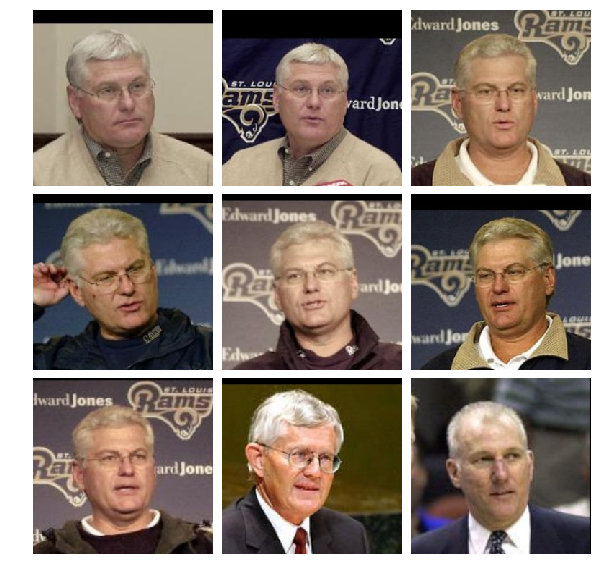

In [46]:
# find similarities using linalg
vecs_sim = np.linalg.norm(np.array([vec_query]) - np.array(vecs_all), axis=1)
# find the best match idx
vec_most_sim = np.argmin(vecs_sim)
print(f'best match roi index is {vec_most_sim} with distance: {vecs_sim[vec_most_sim]}')
# partition the array to get the top 5 roi indices of top 5 matches
nmatches = 9
top_idxs = np.argpartition(vecs_sim, range(nmatches))[:nmatches]
for i in top_idxs:
  print(f'match index: {i}, score: {vecs_sim[i]}')
  
ims = [roi_idx_to_image(x) for x in top_idxs]
max_cols = 3
max_rows = 3
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(10,10))
for idx, im_plt in enumerate(ims[:max_rows*max_cols]):
  row = idx // max_cols
  col = idx % max_cols
  axes[row, col].axis("off")
  im_plt_rgb = cv.cvtColor(im_plt, cv.COLOR_BGR2RGB)
  axes[row, col].imshow(im_plt_rgb, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

In [48]:
from scipy.io import loadmat
metadata = loadmat('/data_store_hdd/datasets/people/imdb_wiki/imdb/imdb.mat')
print(metadata.keys())

```
 For both the IMDb and Wikipedia images we provide a separate .mat file which can be loaded with Matlab containing all the meta information. The format is as follows:

    dob: date of birth (Matlab serial date number)
    photo_taken: year when the photo was taken
    full_path: path to file
    gender: 0 for female and 1 for male, NaN if unknown
    name: name of the celebrity
    face_location: location of the face. To crop the face in Matlab run

    img(face_location(2):face_location(4),face_location(1):face_location(3),:))

    face_score: detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image
    second_face_score: detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.
    celeb_names (IMDB only): list of all celebrity names
    celeb_id (IMDB only): index of celebrity name

The age of a person can be calculated based on the date of birth and the time when the photo was taken (note that we assume that the photo was taken in the middle of the year):

[age,~]=datevec(datenum(wiki.photo_taken,7,1)-wiki.dob); 
```

In [107]:
imdb_data = []
for i, v in enumerate(k):
  print(i, v.shape, v[0])
  if i != 8:
    print(v[0])
  else:

0 (1, 460723) [693726 693726 693726 ... 726831 726831 726831]
1 (1, 460723) [1968 1970 1968 ... 2011 2011 2011]
2 (1, 460723) [array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43')
 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44')
 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43') ...
 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44')
 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44')
 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]
3 (1, 460723) [1. 1. 1. ... 0. 0. 0.]
4 (1, 460723) [array(['Fred Astaire'], dtype='<U12')
 array(['Fred Astaire'], dtype='<U12')
 array(['Fred Astaire'], dtype='<U12') ...
 array(['Jane Levy'], dtype='<U9') array(['Jane Levy'], dtype='<U9')
 array(['Jane Levy'], dtype='<U9')]
5 (1, 460723) [array([[1072.926,  161.838, 1214.784,  303.696]])
 array([[477.184, 100.352, 622.592, 245.76 ]])
 array([[114.96964309, 114.96964309, 451.68657236, 451.

In [106]:
print(k[0][0][1])
print(k[1][0][1])
print(k[2][0][1])
print(k[2][0][1])
print(k[3][0][1])
print(k[4][0][1])
print(k[5][0][1])
print(k[6][0][1])
print(k[7][0][1])
print(k[8][0][1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [104]:
# k[8] is names
for v in k[8][0]:
  print(v)

["'Lee' George Quinones"]
["'Weird Al' Yankovic"]
['2 Chainz']
['50 Cent']
['A Martinez']
['A.D. Miles']
['A.J. Buckley']
['A.J. Cook']
['A.J. Johnson']
['A.J. Langer']
['A.J. McLean']
['A.J. Saudin']
['A.J. Trauth']
['A.R. Rahman']
['AJ Bowen']
['AJ Michalka']
['Aaliyah']
['Aamir Khan']
['Aaron Abrams']
['Aaron Ashmore']
['Aaron Carter']
['Aaron Christian Howles']
['Aaron Coady']
['Aaron D. Spears']
['Aaron Douglas']
['Aaron Eckhart']
['Aaron Farb']
['Aaron Franklin']
['Aaron Hill']
['Aaron Himelstein']
['Aaron Jackson']
['Aaron Jay Rome']
['Aaron Katz']
['Aaron Kwok']
['Aaron Lohr']
['Aaron Lustig']
['Aaron McCusker']
['Aaron Michael Davies']
['Aaron Michael Metchik']
['Aaron Norris']
['Aaron Paul']
['Aaron Pearl']
['Aaron Pedersen']
['Aaron Rodgers']
['Aaron Ruell']
['Aaron Russo']
['Aaron Schwartz']
['Aaron Seltzer']
['Aaron Sorkin']
['Aaron Spelling']
['Aaron Stanford']
['Aaron Taylor-Johnson']
['Aaron Tveit']
['Aaron Wolff']
['Aaron Woodley']
['Aaron Yoo']
['Aaron Zigman']
['Aash

['Alex Karras']
['Alex Kingston']
['Alex Kurtzman']
['Alex Lifeson']
['Alex Macqueen']
['Alex Manette']
['Alex McArthur']
['Alex McCord']
['Alex McKenna']
['Alex Meneses']
['Alex Menglet']
['Alex Meraz']
['Alex Murrel']
['Alex Nesic']
['Alex Neuberger']
['Alex Nevil']
["Alex O'Loughlin"]
['Alex Pettyfer']
['Alex Proyas']
['Alex Rocco']
['Alex Schemmer']
['Alex Smith']
['Alex Solowitz']
['Alex Stevens']
['Alex Trebek']
['Alex Veadov']
['Alex Vincent']
['Alex Weed']
['Alex Winter']
['Alex Wolff']
['Alex Zane']
['Alex van Warmerdam']
['Alexa Chung']
['Alexa Davalos']
['Alexa Havins']
['Alexa Kenin']
['Alexa Nikolas']
['Alexa PenaVega']
['Alexander Armstrong']
['Alexander Beyer']
['Alexander Cary']
['Alexander Cendese']
['Alexander Dreymon']
['Alexander Fehling']
['Alexander Godunov']
['Alexander Gould']
['Alexander Karim']
['Alexander Leeb']
['Alexander Ludwig']
['Alexander Martella']
['Alexander Martin']
['Alexander Payne']
['Alexander Polinsky']
['Alexander Salkind']
['Alexander Sano']


['Andi Vasluianu']
['Andie MacDowell']
['Andra Fuller']
['Andre Braugher']
['Andre Gower']
['Andre Royo']
['Andre Schneider']
['Andrea Allan']
['Andrea Anders']
['Andrea Arnold']
['Andrea Barber']
['Andrea Bendewald']
['Andrea Bocelli']
['Andrea Bogart']
['Andrea Bosca']
['Andrea Bowen']
['Andrea Brooks']
['Andrea Corr']
['Andrea Di Stefano']
['Andrea Elson']
['Andrea Evans']
['Andrea Gabriel']
['Andrea Lewis']
['Andrea Lowe']
['Andrea Lui']
['Andrea Marcovicci']
['Andrea Martin']
['Andrea Montenegro']
['Andrea Morris']
['Andrea Occhipinti']
['Andrea Osvárt']
['Andrea Parker']
['Andrea Powell']
['Andrea Riseborough']
['Andrea Roth']
['Andrea Savage']
['Andrea Stefancikova']
['Andreas Dresen']
['Andreas Günther']
['Andreas Katsulas']
['Andreas Prochaska']
['Andreas Wisniewski']
['Andrei Arlovski']
['Andrei Claude']
['Andrew Adamson']
['Andrew Airlie']
['Andrew Bergman']
['Andrew Bryniarski']
['Andrew Buchan']
['Andrew Bujalski']
['Andrew Caldwell']
['Andrew Clarke']
['Andrew Daly']
['An

['Antonia Campbell-Hughes']
['Antonia Ellis']
['Antonia Rey']
['Antonia Thomas']
['Antonie Kamerling']
['Antonio Albanese']
['Antonio Badrani']
['Antonio Banderas']
['Antonio Campos']
['Antonio Cupo']
['Antonio Fargas']
['Antonio Mancino']
['Antonio Ortiz']
['Antonio Sabato']
['Antonio Sabato Jr.']
['Antonio Tarver']
['Antonio Te Maioha']
['Antonio Velázquez']
['Antonio de la Torre']
['Antony Hamilton']
['Antony Langdon']
['Antony Sher']
['Antony Starr']
['Antwon Tanner']
['Antwone Fisher']
['Anupam Kher']
['Anurag Kashyap']
['Anushka Sharma']
['Anya Kop']
['Anya Monzikova']
['Apichatpong Weerasethakul']
['Apl.de.Ap']
['Apollonia Kotero']
['Apolo Ohno']
['April Bowlby']
['April Grace']
['April L. Hernandez']
['April Marie Eden']
["April O'Neil"]
['April Pearson']
['April Scott']
['April Telek']
['April Winchell']
['Aqib Khan']
['Arabella Holzbog']
['Arabella Weir']
['Aramis Knight']
['Aras Baskauskas']
['Arch Johnson']
['Archie Campbell']
['Archie Kao']
['Archie Panjabi']
["Ardal O'Han

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['Bill Pullman']
['Bill Quinn']
['Bill Romanowski']
['Bill Sage']
['Bill Simmons']
['Bill Skarsgård']
['Bill Smitrovich']
['Bill Stinchcomb']
['Bill Travers']
['Bill Walton']
['Bill Withers']
['Bill Wyman']
['Bille August']
['Billi Bruno']
['Billie Jean King']
['Billie Joe Armstrong']
['Billie Lourd']
['Billie Piper']
['Billie Whitelaw']
['Billy Aaron Brown']
['Billy Barty']
['Billy Blanks']
['Billy Bob Thornton']
['Billy Boyd']
['Billy Burke']
['Billy Bush']
['Billy Campbell']
['Billy Connolly']
['Billy Corgan']
['Billy Crudup']
['Billy Crystal']
['Billy Curtis']
['Billy Dee Williams']
['Billy Drago']
['Billy Gallo']
['Billy Gardell']
['Billy Gibbons']
['Billy Green Bush']
['Billy Idol']
['Billy Joel']
['Billy L. Sullivan']
['Billy Lockwood']
['Billy Lush']
['Billy Magnussen']
['Billy Mays']
['Billy Miller']
['Billy Murray']
['Billy Porter']
['Billy Preston']
['Billy Ray Cyrus']
['Billy Rosemberg']
['Billy Sands']
['Billy Unger']
['Billy Warlock']
['Billy Wilder']
['Billy Wirth']
['B

['Brian Scannell']
['Brian Skala']
['Brian Smith']
['Brian Stokes Mitchell']
['Brian Swardstrom']
['Brian Tee']
['Brian Thompson']
['Brian Tochi']
['Brian Unger']
['Brian Van Holt']
['Brian Vander Ark']
['Brian White']
['Brian Williams']
['Brian Wilson']
['Brian Wimmer']
['Brian Woodward']
["Brian d'Arcy James"]
['Briana Evigan']
['Briana Lane']
['Brianna Brown']
['Brianne Davis']
['Brianne Moncrief']
['Bridger Zadina']
['Bridget Fonda']
['Bridget Hall']
['Bridget Marquardt']
['Bridget Moynahan']
['Bridget Regan']
['Bridgetta Tomarchio']
['Bridgette Wilson-Sampras']
['Bridgid Coulter']
['Bridgit Mendler']
['Bridie Latona']
['Brie Howard']
['Brie Larson']
['Brien Perry']
['Brigid Brannagh']
['Brigitte Bardot']
['Brigitte Fossey']
['Brigitte Lin']
['Brigitte Nielsen']
['Brillante Mendoza']
['Brinke Stevens']
['Brion James']
['Bristol Palin']
['Brit Marling']
['Brit Morgan']
['Britney Spears']
['Britt Ekland']
['Britt Irvin']
['Britt McKillip']
['Britt Robertson']
['Brittany Allen']
['Bri

['Carolina Bermudez']
['Carolina Crescentini']
['Carolina Hoyos']
['Caroline Aaron']
['Caroline Bliss']
['Caroline Carver']
['Caroline Chikezie']
["Caroline D'Amore"]
['Caroline Dhavernas']
['Caroline Ducey']
['Caroline Goodall']
['Caroline Kennedy']
['Caroline Lagerfelt']
['Caroline Manzo']
['Caroline Maria Winberg']
['Caroline Munro']
['Caroline Reitman']
['Caroline Rhea']
['Caroline Sunshine']
['Caroline Tillette']
['Caroline Williams']
['Caroll Spinney']
['Carolyn Conwell']
['Carolyn Hennesy']
['Carolyn Jones']
['Carolyn Lawrence']
['Carolyn Murphy']
['Carolyn Pickles']
['Carolyn Purdy-Gordon']
['Carrie Ann Inaba']
['Carrie Brownstein']
['Carrie Coon']
['Carrie Finklea']
['Carrie Fisher']
['Carrie Genzel']
['Carrie Henn']
['Carrie Keagan']
['Carrie Lorraine']
['Carrie MacLemore']
['Carrie Preston']
['Carrie Snodgress']
['Carrie Underwood']
['Carrie-Anne Moss']
['Carroll Baker']
['Carroll Ballard']
["Carroll O'Connor"]
['Carré Otis']
['Carsen Flowers']
['Carson Brown']
['Carson Daly

['Chloe Bailey']
['Chloe Bennet']
['Chloe Bridges']
['Chloe Dykstra']
['Chloe Greenfield']
['Chloe Pirrie']
['Chloe Rose']
['Chloe Webb']
['Chloé Robichaud']
['Chloë Annett']
['Chloë Grace Moretz']
['Chloë Sevigny']
['Chord Overstreet']
['Chris Ackerman']
['Chris Addison']
['Chris Andrew Ciulla']
['Chris Ashworth']
['Chris Barrie']
['Chris Bauer']
['Chris Bender']
['Chris Berman']
['Chris Bosh']
['Chris Botti']
['Chris Brown']
['Chris Bruno']
['Chris Burns']
['Chris Carmack']
['Chris Carter']
['Chris Christie']
['Chris Coghill']
['Chris Colfer']
['Chris Columbus']
['Chris Cooper']
['Chris Cornell']
['Chris Coy']
['Chris Cuomo']
['Chris Daughtry']
['Chris Diamantopoulos']
['Chris Eigeman']
['Chris Elliott']
['Chris Ellis']
['Chris Evans']
['Chris Evert']
['Chris Eyre']
['Chris Farley']
['Chris Fisher']
['Chris Furrh']
['Chris Gardner']
['Chris Gartin']
['Chris Gauthier']
['Chris Geere']
['Chris Gore']
['Chris Greene']
['Chris Hardwick']
['Chris Harrison']
['Chris Haywood']
['Chris Hemsw

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['Cynthia Myers']
['Cynthia Nixon']
['Cynthia Preston']
['Cynthia Rhodes']
['Cynthia Rowley']
['Cynthia Sikes']
['Cynthia Stevenson']
['Cynthia Watros']
['Cyrielle Clair']
['Cyril Collard']
['Cyril Delevanti']
['Cyril Nri']
['Cyrus Nowrasteh']
['Cécile De France']
['Cédric Klapisch']
['Céline Dion']
["D'Mitch Davis"]
['D. David Morin']
['D.B. Sweeney']
['D.B. Woodside']
['D.C. Douglas']
['D.J. Caruso']
['D.J. Cotrona']
['D.L. Hughley']
['D.R. Nanayakkara']
['D.W. Brown']
['D.W. Moffett']
['DJ Qualls']
['DMX']
['Da Brat']
['Dabbs Greer']
['Dabney Coleman']
['Dack Rambo']
['Daddy Yankee']
['Daena E. Title']
['Dag Malmberg']
['Dagmara Dominczyk']
['Dagney Kerr']
['Dagur Kári']
['Daisy Bevan']
['Daisy Eagan']
['Daisy Fuentes']
['Daisy Haggard']
['Daisy Lowe']
['Daisy Ridley']
['Daisy von Scherler Mayer']
['Dakin Matthews']
['Dakota Blue Richards']
['Dakota Fanning']
['Dakota Goyo']
['Dakota Johnson']
['Dal-su Oh']
['Dale Dye']
['Dale Earnhardt Jr.']
['Dale Godboldo']
['Dale Midkiff']
['Dal

['David Byrne']
['David C. Bunners']
['David Cage']
['David Calder']
['David Campbell']
['David Carradine']
['David Caruso']
['David Cassidy']
['David Castro']
['David Charvet']
['David Chase']
['David Chokachi']
['David Clayton Rogers']
['David Clennon']
['David Conrad']
['David Cook']
['David Copperfield']
['David Crane']
['David Cronenberg']
['David Crosby']
['David Cross']
['David Cubitt']
['David Dawson']
['David DeLuise']
['David Dencik']
['David Denman']
['David Diaan']
['David Dobkin']
['David Doremus']
['David Downing']
['David Doyle']
['David Duchovny']
['David Dukes']
['David E. Kelley']
['David Edwards']
['David Eick']
['David Eigenberg']
['David Elliot']
['David Ellison']
['David Essex']
['David Faustino']
['David Fincher']
['David Foster']
['David Frankel']
['David Franzoni']
['David Frost']
['David Fumero']
['David Furnish']
['David Gallagher']
['David Gandy']
['David Garrett']
['David Garrison']
['David Geffen']
['David Gelb']
['David Gere']
['David Giuntoli']
['David G

['Dev']
['Dev Anand']
['Dev Patel']
['Devanny Pinn']
['Devid Striesow']
['Devin DeVasquez']
['Devin Lima']
['Devin Oatway']
['Devin Ratray']
['Devon Aoki']
['Devon Bostick']
['Devon Ericson']
['Devon Gearhart']
['Devon Graye']
['Devon Gummersall']
['Devon Odessa']
['Devon Sawa']
['Devon Werkheiser']
['Dewey Weber']
['Dexter Fletcher']
['Dharmendra']
['Dia Mirza']
['Diablo Cody']
['Diahann Carroll']
['Diahnne Abbott']
['Dian Bachar']
['Diana DeGarmo']
['Diana Dors']
['Diana Douglas']
['Diana Ewing']
['Diana García']
['Diana Krall']
['Diana Lee Inosanto']
['Diana Maria Riva']
['Diana Muldaur']
['Diana Ossana']
['Diana Palazón']
['Diana Rice']
['Diana Rigg']
['Diana Ross']
['Diana Scarwid']
['Diane Baker']
['Diane Cilento']
['Diane Delano']
['Diane English']
['Diane Farr']
['Diane Fleri']
['Diane Franklin']
['Diane Grayson']
['Diane Guerrero']
['Diane Keaton']
['Diane Klimaszewski']
['Diane Kruger']
['Diane Ladd']
['Diane Lane']
['Diane Mizota']
['Diane Neal']
['Diane Salinger']
['Diane S

['Ed Peck']
['Ed Quinn']
['Ed Sanders']
['Ed Sheeran']
['Ed Skrein']
['Ed Solomon']
['Ed Speleers']
['Ed Stoppard']
['Ed Westwick']
['Edd Byrnes']
['Eddie Albert']
['Eddie Alderson']
['Eddie Alfano']
['Eddie Baroo']
['Eddie Cahill']
['Eddie Cibrian']
['Eddie Constantine']
['Eddie Daniels']
['Eddie Deezen']
['Eddie Garcia']
['Eddie Griffin']
['Eddie Hassell']
['Eddie Izzard']
['Eddie Kaye Thomas']
['Eddie Marsan']
['Eddie Matos']
['Eddie McClintock']
['Eddie McGee']
['Eddie Mekka']
['Eddie Mills']
['Eddie Mui']
['Eddie Murphy']
['Eddie Peng']
['Eddie Redmayne']
['Eddie Rouse']
['Eddie Shin']
['Eddie Spears']
['Eddie Steeples']
['Eddie Vedder']
['Eddra Gale']
['Eden Brolin']
['Eden Espinosa']
['Eden Riegel']
['Eden Sher']
['Edgar Hansen']
['Edgar Morais']
['Edgar Selge']
['Edgar Wright']
['Edi Gathegi']
['Edie Adams']
['Edie Falco']
['Edie McClurg']
['Edita Malovcic']
["Edith 'Little Edie' Bouvier Beale"]
['Edith Bouvier Beale']
['Edith Bowman']
['Edith Evans']
['Edith Massey']
['Edith S

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['Eun-hye Yun']
['Eunice Gayson']
['Eunice Kennedy Shriver']
['Euros Lyn']
['Euzhan Palcy']
['Eva Amurri Martino']
['Eva Birthistle']
['Eva Fritjofson']
['Eva Gabor']
['Eva Green']
['Eva Habermann']
['Eva Herzigova']
['Eva LaRue']
['Eva Longoria']
['Eva Loseth']
['Eva Löbau']
['Eva Marcille']
['Eva Marie Saint']
['Eva Mendes']
['Eva Röse']
['Eva Sayer']
['Eva van de Wijdeven']
['Eva-Maria Leonardou']
['Evan Adams']
['Evan Ellingson']
['Evan Handler']
['Evan Hart']
['Evan King']
['Evan Lysacek']
['Evan Marriott']
['Evan Mathew Weinstein']
['Evan Parke']
['Evan Peters']
['Evan Rachel Wood']
['Evan Richards']
['Evan Ross']
['Evander Holyfield']
['Evangeline Lilly']
['Evanna Lynch']
['Eve']
['Eve Best']
['Eve Ensler']
['Eve Gordon']
['Eve Harlow']
['Eve Hewson']
['Eve Mauro']
['Eve Mavrakis']
['Eve Myles']
['Eve Plumb']
['Evelien Bosmans']
['Evelyne Brochu']
['Ever Carradine']
['Everett McGill']
['Everlyn Sampi']
['Evgeny Afineevsky']
['Evi Quaid']
['Evie Thompson']
["Evita Muñoz 'Chachita

['Gabrielle Union']
['Gaby Dellal']
['Gaby Hoffmann']
['Gad Elmaleh']
['Gael García Bernal']
['Gaelan Connell']
['Gage Golightly']
['Gage Munroe']
['Gaia Weiss']
['Gail Berman']
['Gail Fisher']
["Gail O'Grady"]
['Gail Porter']
['Gail Simmons']
['Gail Strickland']
['Gailard Sartain']
['Gaite Jansen']
['Gaius Charles']
['Gal Gadot']
['Galadriel Stineman']
['Gale Anne Hurd']
['Gale Harold']
['Galen Gering']
['Galina Jovovich']
['Galt Niederhoffer']
['Game']
['Gameela Wright']
['Gamze Özçelik']
['Garcelle Beauvais']
['Gareth David-Lloyd']
['Gareth Neame']
['Gareth Thomas']
['Garikayi Mutambirwa']
['Garret Dillahunt']
['Garrett Backstrom']
['Garrett Brawith']
['Garrett Hedlund']
['Garrett M. Brown']
['Garrett Morris']
['Garrett Ryan']
['Garrett Strommen']
['Garrett Wang']
['Garrick Hagon']
['Garrison Keillor']
['Garry Chalk']
['Garry Marshall']
['Garry Shandling']
['Garry Trudeau']
['Garth Brooks']
['Garth Jennings']
['Gary Ambrosia']
['Gary Anthony Sturgis']
['Gary Anthony Williams']
['Gar

['Gordon Michael Woolvett']
['Gordon Pinsent']
['Gordon Ramsay']
['Gordon Tootoosis']
['Gordon Willis']
['Gordy Hoffman']
['Gore Verbinski']
['Gore Vidal']
['Gottfried John']
['Govinda']
['Gower Champion']
['Grace Bannon']
['Grace Gealey']
['Grace Gummer']
['Grace Helbig']
['Grace Hightower']
['Grace Johnston']
['Grace Jones']
['Grace Lee Whitney']
['Grace Morley']
['Grace Park']
['Grace Phipps']
['Grace Potter']
['Grace Rolek']
['Grace Slick']
['Grace Victoria Cox']
['Grace Zabriskie']
["Gracee O'Brien"]
['Graciano Dias']
['Gracie Dzienny']
['Gracy Singh']
['Graeme Revell']
['Graham Chapman']
['Graham Crowden']
['Graham Curry']
['Graham Elliot']
['Graham Greene']
['Graham Jarvis']
['Graham King']
['Graham McTavish']
['Graham Moore']
['Graham Nash']
['Graham Norton']
['Graham Parker']
['Graham Patrick Martin']
['Graham Phillips']
['Graham Shiels']
['Graham Stark']
['Grandpa Jones']
['Grant Bowler']
['Grant Cramer']
['Grant Goodman']
['Grant Gustin']
['Grant Heslov']
['Grant Imahara']
[

['Hector Elizondo']
['Hedy Burress']
['Hee-seon Kim']
['Heidi Albertsen']
['Heidi Fleiss']
['Heidi Hawking']
['Heidi Jo Markel']
['Heidi Kling']
['Heidi Klum']
['Heidi Mark']
['Heidi Montag']
['Heidi Mueller']
['Heidi Sorenson']
['Heidi Swedberg']
['Heidi Thomas']
['Heidi von Palleske']
['Heike Makatsch']
['Heino Ferch']
['Heinz Bennent']
['Heitor Pereira']
['Helen Baxendale']
['Helen Carey']
['Helen Colliander']
['Helen Fielding']
['Helen Gurley Brown']
['Helen Hayes']
['Helen Hunt']
['Helen Kleeb']
['Helen Labdon']
['Helen Martin']
['Helen McCrory']
['Helen Mirren']
['Helen Reddy']
['Helen Shaver']
['Helen Shaw']
['Helen Slater']
['Helena Bonham Carter']
['Helena Christensen']
['Helena Mattsson']
['Helio Castroneves']
['Hella Joof']
['Helmut Berger']
['Helmut Huber']
['Hemky Madera']
['Henning Moritzen']
['Henning Valin Jakobsen']
['Henri Serre']
['Henriette Confurius']
['Henriette Mantel']
['Henrik Mestad']
['Henrik Rafaelsen']
['Henrik Ruben Genz']
['Henry Bean']
['Henry Bromell']


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['Jane Carr']
['Jane Curtin']
['Jane Espenson']
['Jane Fallon']
['Jane Fonda']
['Jane Goldman']
['Jane Hajduk']
['Jane Horrocks']
['Jane Kaczmarek']
['Jane Krakowski']
['Jane Leeves']
['Jane Levy']
['Jane Lynch']
['Jane March']
['Jane McGregor']
['Jane Merrow']
['Jane Pauley']
['Jane Powell']
['Jane Rosenthal']
['Jane Russell']
['Jane Seymour']
['Jane Sibbett']
['Jane Wiedlin']
['Jane Wyatt']
['Janeane Garofalo']
['Janel Moloney']
['Janel Parrish']
['Janelle Monáe']
['Janelle Pierzina']
['Janet Evanovich']
['Janet Fielding']
['Janet Hubert']
['Janet Jackson']
['Janet Jones']
['Janet Leigh']
['Janet McTeer']
['Janet Montgomery']
['Janet Suzman']
['Janette Manrara']
['Janette Scott']
['Janice Crystal']
['Janice Dickinson']
['Janice Lynde']
['Janice Rule']
['Janin Reinhardt']
['Janina Gavankar']
['Janine Turner']
['Janis Joplin']
['Jann Arden']
['Jann Carl']
['Jann Wenner']
['Jansen Panettiere']
['January Jones']
['Janusz Kaminski']
['Jareb Dauplaise']
['Jared Fogle']
['Jared Followill']


['Jennifer Hudson']
['Jennifer Irwin']
['Jennifer Jason Leigh']
['Jennifer Jones']
['Jennifer Jostyn']
['Jennifer Korbin']
['Jennifer Lafleur']
['Jennifer Lawrence']
['Jennifer Lien']
['Jennifer Lim']
['Jennifer Lopez']
['Jennifer Love Hewitt']
['Jennifer Lynn Warren']
['Jennifer Missoni']
['Jennifer Morrison']
['Jennifer Murphy']
['Jennifer Nettles']
['Jennifer Nicholson']
["Jennifer O'Neill"]
['Jennifer Rae Daykin']
['Jennifer Riker']
['Jennifer Rovero']
['Jennifer Rubin']
['Jennifer Runyon']
['Jennifer Salt']
['Jennifer Saunders']
['Jennifer Savidge']
['Jennifer Schwalbach Smith']
['Jennifer Siebel Newsom']
['Jennifer Sky']
['Jennifer Spence']
['Jennifer Stone']
['Jennifer Taylor']
['Jennifer Tilly']
['Jennifer Tisdale']
['Jennifer Todd']
['Jennifer Ulrich']
['Jennifer Veal']
['Jennifer Walcott']
['Jennifer Warren']
['Jennifer Westfeldt']
['Jennifer Widerstrom']
['Jennifer Youngs']
['Jennifer Yuh']
['Jenny Agutter']
['Jenny Gago']
['Jenny Jones']
['Jenny Lewis']
['Jenny Lumet']
['Je

['Jodi Long']
["Jodi Lyn O'Keefe"]
['Jodi Picoult']
['Jodi Thelen']
['Jodie Foster']
['Jodie Markell']
['Jodie Sweetin']
['Jodie Whittaker']
['Jody Thompson']
['Jody Watley']
['Joe Anderson']
['Joe Armstrong']
['Joe Basile']
['Joe Berlinger']
['Joe Biden']
['Joe Breen']
['Joe Carnahan']
['Joe Cobden']
['Joe Cole']
['Joe Cornish']
['Joe Costner']
['Joe Dallesandro']
['Joe Dante']
['Joe Dempsie']
['Joe Dinicol']
['Joe Dixon']
['Joe Don Baker']
['Joe Duer']
['Joe E. Tata']
['Joe Egender']
['Joe Elliott']
['Joe Estevez']
['Joe Eszterhas']
['Joe Farina']
['Joe Flaherty']
['Joe Flanigan']
['Joe Frazier']
['Joe Hammerstone']
['Joe Hill']
['Joe Jackson']
['Joe Johnston']
['Joe Jonas']
['Joe Keenan']
['Joe Klecko']
['Joe Knezevich']
['Joe Lando']
['Joe Letteri']
['Joe Lo Truglio']
['Joe Manganiello']
['Joe Mantegna']
['Joe Mantell']
['Joe Mantello']
['Joe Morton']
['Joe Nussbaum']
['Joe Odagiri']
['Joe Pantoliano']
['Joe Perrino']
['Joe Perry']
['Joe Pesci']
['Joe Piscopo']
['Joe Prospero']
['J

['Johnny Nguyen']
['Johnny Pacar']
['Johnny Rzeznik']
['Johnny Sequoyah']
['Johnny Simmons']
['Johnny Weir']
['Johnny Whitaker']
['Johnny Whitworth']
['Johnny Winter']
['Johnny Yong Bosch']
['Joie Lee']
['Jolene Blalock']
['Jolene Purdy']
['Jolene Van Vugt']
['Jolie Jenkins']
['Jolie Vanier']
['Jon Abrahams']
['Jon Amiel']
['Jon Avnet']
['Jon Bernthal']
['Jon Bon Jovi']
['Jon Briddell']
['Jon Brion']
['Jon Caliri']
['Jon Cassar']
['Jon Chaffin']
['Jon Cor']
['Jon Cryer']
['Jon Cypher']
['Jon Dore']
['Jon Favreau']
['Jon Finch']
['Jon Foo']
['Jon Foster']
['Jon Glaser']
['Jon Gries']
['Jon Hager']
['Jon Hamm']
['Jon Heder']
['Jon Hurwitz']
['Jon Jacobs']
['Jon Kilik']
['Jon Kit Lee']
['Jon Kortajarena']
['Jon Krakauer']
['Jon Landau']
['Jon Lange']
['Jon Lee Brody']
['Jon Lindstrom']
['Jon Lovitz']
['Jon M. Chu']
['Jon McLaughlin']
['Jon Michael Davis']
['Jon Pertwee']
['Jon Peters']
['Jon Polito']
['Jon Prescott']
['Jon Provost']
['Jon Reep']
['Jon Robin Baitz']
['Jon Ronson']
['Jon S.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['Kathleen Robertson']
['Kathleen Rose Perkins']
['Kathleen Turner']
['Kathrine Narducci']
['Kathryn Bigelow']
['Kathryn Boyd']
['Kathryn Drysdale']
['Kathryn Erbe']
['Kathryn Hahn']
['Kathryn Harrold']
['Kathryn Joosten']
['Kathryn Layng']
['Kathryn Leigh Scott']
['Kathryn Lyn']
['Kathryn McCormick']
['Kathryn Morris']
['Kathryn Prescott']
['Kathryn Walker']
['Kathy Baker']
['Kathy Bates']
['Kathy Brier']
['Kathy Burke']
['Kathy Garver']
['Kathy Griffin']
['Kathy Hilton']
['Kathy Ireland']
['Kathy Kinney']
['Kathy Najimy']


KeyboardInterrupt: 

In [66]:
len(k[0][4][0])

460723